# Swin UNETR Training with Uncertainty for UT-EndoMRI

End-to-end Google Colab workflow for training a 3D Swin UNETR with Monte-Carlo dropout and test-time augmentation (TTA) uncertainty on the UT-EndoMRI dataset.

## 1. Environment & Paths
Mount Google Drive, mirror the repository, install dependencies, and verify GPU/data availability.

In [1]:
from google.colab import drive

drive.mount("/content/drive")

import os
import sys
import subprocess
from pathlib import Path

DRIVE_ROOT = "/content/drive/MyDrive"
REPO_DIR = f"{DRIVE_ROOT}/endo-seg"
WORK_DIR = "/content/endo-seg"
DATASET_DIR = f"{DRIVE_ROOT}/UT-EndoMRI"

os.environ["DRIVE_ROOT"] = DRIVE_ROOT
os.environ["REPO_DIR"] = REPO_DIR
os.environ["WORK_DIR"] = WORK_DIR
os.environ["DATASET_DIR"] = DATASET_DIR

print(f"Drive root: {DRIVE_ROOT}\n" \
      f"Repo dir: {REPO_DIR}\n" \
      f"Work dir: {WORK_DIR}\n" \
      f"Dataset dir: {DATASET_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive root: /content/drive/MyDrive
Repo dir: /content/drive/MyDrive/endo-seg
Work dir: /content/endo-seg
Dataset dir: /content/drive/MyDrive/UT-EndoMRI


In [2]:
import os
import subprocess
import sys

if not os.path.isdir(REPO_DIR):
    print("Cloning refactor-structure branch...")
    subprocess.run([
        "git",
        "clone",
        "-b",
        "refactor-structure",
        "https://github.com/sehajbath/endo-seg.git",
        REPO_DIR,
    ], check=True)
else:
    print("Repository already present on Drive. Pulling latest updates...")
    subprocess.run(["git", "-C", REPO_DIR, "pull"], check=True)

subprocess.run(["ln", "-sfn", REPO_DIR, WORK_DIR], check=True)
os.chdir(WORK_DIR)
if os.path.join(WORK_DIR, "src") not in sys.path:
    sys.path.append(os.path.join(WORK_DIR, "src"))

%pip install -r requirements.txt
%pip install -e .

Repository already present on Drive. Pulling latest updates...
Obtaining file:///content/drive/MyDrive/endo-seg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: endo-uncertainty-seg
    Found existing installation: endo-uncertainty-seg 0.1.0
    Uninstalling endo-uncertainty-seg-0.1.0:
      Successfully uninstalled endo-uncertainty-seg-0.1.0
  Running setup.py develop for endo-uncertainty-seg


In [3]:

import json
import torch

print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Total GPU memory (GB): {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f}")

assert os.path.isdir(DATASET_DIR), f"Dataset directory not found: {DATASET_DIR}"
for split_dir in ("D1_MHS", "D2_TCPW"):
    path = os.path.join(DATASET_DIR, split_dir)
    assert os.path.isdir(path), f"Missing dataset subset: {path}"

splits_file = os.path.join(REPO_DIR, "data", "splits", "split_info.json")
os.makedirs(os.path.dirname(splits_file), exist_ok=True)
if not os.path.isfile(splits_file):
    print("Creating paper-aligned D2 split file...")
    subprocess.run([
        "python",
        "scripts/create_splits.py",
        "--data_root",
        DATASET_DIR,
        "--dataset",
        "D2_TCPW",
        "--output",
        splits_file,
        "--use_paper_split",
    ], check=True)
else:
    print(f"Using existing splits file: {splits_file}")


GPU: NVIDIA A100-SXM4-40GB
Total GPU memory (GB): 42.47
Using existing splits file: /content/drive/MyDrive/endo-seg/data/splits/split_info.json


## 2. Configuration
Single source-of-truth for paths, datasets, model, training, and uncertainty parameters.

In [4]:

import os
from pprint import pprint

config = {
    "drive_root": DRIVE_ROOT,
    "project_root": REPO_DIR,
    "work_dir": WORK_DIR,
    "dataset_dir": DATASET_DIR,
    "splits_file": splits_file,
    "checkpoint_dir": os.path.join(REPO_DIR, "experiments", "checkpoints_swin_unetr"),
    "log_dir": os.path.join(REPO_DIR, "experiments", "logs_swin_unetr"),
    "pretrain_dataset": "D2_TCPW",
    "finetune_dataset": "D1_MHS",
    "use_finetune_on_D1": False,
    "sequences": ["T2FS"],
    "structures": ["ut", "ov", "em"],
    "num_classes": 4,
    "target_spacing": (5.0, 5.0, 5.0),
    "target_size": (128, 128, 32),
    "intensity_clip_percentiles": (1, 99),
    "epochs": 150,
    "batch_size": 2,
    "num_workers": 4,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "grad_clip": 1.0,
    "mixed_precision": True,
    "save_frequency": 10,
    "feature_size": 48,
    "drop_rate": 0.1,
    "attn_drop_rate": 0.1,
    "dropout_path_rate": 0.1,
    "use_checkpointing": True,
    "sw_batch_size": 2,
    "infer_overlap": 0.5,
    "use_mc_dropout": True,
    "num_mc_samples": 8,
    "use_tta": True,
    "num_tta_transforms": 4,
    "seed": 42,
}


def print_config(cfg):
    pprint(cfg)

print_config(config)


{'attn_drop_rate': 0.1,
 'batch_size': 2,
 'checkpoint_dir': '/content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr',
 'dataset_dir': '/content/drive/MyDrive/UT-EndoMRI',
 'drive_root': '/content/drive/MyDrive',
 'drop_rate': 0.1,
 'dropout_path_rate': 0.1,
 'epochs': 150,
 'feature_size': 48,
 'finetune_dataset': 'D1_MHS',
 'grad_clip': 1.0,
 'infer_overlap': 0.5,
 'intensity_clip_percentiles': (1, 99),
 'learning_rate': 0.0001,
 'log_dir': '/content/drive/MyDrive/endo-seg/experiments/logs_swin_unetr',
 'mixed_precision': True,
 'num_classes': 4,
 'num_mc_samples': 8,
 'num_tta_transforms': 4,
 'num_workers': 4,
 'pretrain_dataset': 'D2_TCPW',
 'project_root': '/content/drive/MyDrive/endo-seg',
 'save_frequency': 10,
 'seed': 42,
 'sequences': ['T2FS'],
 'splits_file': '/content/drive/MyDrive/endo-seg/data/splits/split_info.json',
 'structures': ['ut', 'ov', 'em'],
 'sw_batch_size': 2,
 'target_size': (128, 128, 32),
 'target_spacing': (5.0, 5.0, 5.0),
 'use_checkpointing

## 3. Data Loading & Augmentation
Reuse the project's dataset/preprocessing helpers and build PyTorch dataloaders.

In [5]:

import random
import numpy as np
import torch


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(config["seed"])


In [6]:

from torch.utils.data import DataLoader

from endo_seg.data import EndoMRIDataset, MRIPreprocessor, load_data_splits
from endo_seg.data.augment.transforms import get_train_transforms

splits = load_data_splits(config["splits_file"])
print(f"Train subjects: {len(splits['train'])}")
print(f"Val subjects: {len(splits['val'])}")
print(f"Test subjects: {len(splits['test'])}")

preprocessor = MRIPreprocessor(
    target_spacing=config["target_spacing"],
    target_size=config["target_size"],
    intensity_clip_percentiles=config["intensity_clip_percentiles"],
    normalize_method="min_max",
)

train_aug_cfg = {
    "random_flip_prob": 0.5,
    "random_rotation": 20,
    "random_translation": 15,
    "random_elastic_deform": True,
    "random_gamma": [0.9, 1.1],
    "random_gaussian_noise": 0.01,
}
train_transform = get_train_transforms(train_aug_cfg)

train_dataset = EndoMRIDataset(
    data_root=config["dataset_dir"],
    subject_ids=splits["train"],
    sequences=config["sequences"],
    structures=config["structures"],
    dataset_name=config["pretrain_dataset"],
    preprocessor=preprocessor,
    transform=train_transform,
)
val_dataset = EndoMRIDataset(
    data_root=config["dataset_dir"],
    subject_ids=splits["val"],
    sequences=config["sequences"],
    structures=config["structures"],
    dataset_name=config["pretrain_dataset"],
    preprocessor=preprocessor,
)
test_dataset = EndoMRIDataset(
    data_root=config["dataset_dir"],
    subject_ids=splits["test"],
    sequences=config["sequences"],
    structures=config["structures"],
    dataset_name=config["pretrain_dataset"],
    preprocessor=preprocessor,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=config["num_workers"],
    pin_memory=True,
    drop_last=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config["num_workers"],
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config["num_workers"],
    pin_memory=True,
)

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Train subjects: 6
Val subjects: 2
Test subjects: 30
Train batches per epoch: 3
Val batches: 2


In [7]:

batch = next(iter(train_loader))
print("Image batch shape:", batch["image"].shape)
print("Label batch shape:", batch["label"].shape)
print("Subject IDs example:", batch.get("subject_id", [])[:3])


Image batch shape: torch.Size([2, 1, 128, 128, 32])
Label batch shape: torch.Size([2, 128, 128, 32])
Subject IDs example: ['D2-002', 'D2-004']


## 4. Model & Trainer Setup
Instantiate the Swin UNETR with uncertainty utilities and wire up the MONAI-style trainer.

In [8]:

import torch
from endo_seg.models.swin_unetr_uncertainty import SwinUNETRWithUncertainty

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETRWithUncertainty(
    #img_size=config["target_size"],
    in_channels=len(config["sequences"]),
    out_channels=config["num_classes"],
    feature_size=config["feature_size"],
    drop_rate=config["drop_rate"],
    attn_drop_rate=config["attn_drop_rate"],
    dropout_path_rate=config["dropout_path_rate"],
    use_checkpoint=config["use_checkpointing"],
    roi_size=config["target_size"],
    sw_batch_size=config["sw_batch_size"],
    infer_overlap=config["infer_overlap"],
    device=device,
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model on {device} with {total_params/1e6:.2f}M trainable params")


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Model on cuda with 62.19M trainable params


In [9]:

from endo_seg.training.swin_unetr_trainer import train_loop

history = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device,
)


/content/drive/MyDrive/endo-seg/src/endo_seg/training/swin_unetr_trainer.py:202: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=mixed_precision)
/content/drive/MyDrive/endo-seg/src/endo_seg/training/swin_unetr_trainer.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=mixed_precision):
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torc

Val Epoch [10/150] Step [2/2] Dice: 0.2473
Saved checkpoint: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/latest.pth
New best Dice 0.2473. Saved: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/best.pth
Val Epoch [20/150] Step [2/2] Dice: 0.2499
Saved checkpoint: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/latest.pth
New best Dice 0.2499. Saved: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/best.pth
Val Epoch [30/150] Step [2/2] Dice: 0.2494
Saved checkpoint: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/latest.pth
Val Epoch [40/150] Step [2/2] Dice: 0.2494
Saved checkpoint: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/latest.pth
Val Epoch [50/150] Step [2/2] Dice: 0.2493
Saved checkpoint: /content/drive/MyDrive/endo-seg/experiments/checkpoints_swin_unetr/latest.pth
Val Epoch [60/150] Step [2/2] Dice: 0.2493
Saved checkpoint: /content/drive/MyDrive/endo-seg/ex

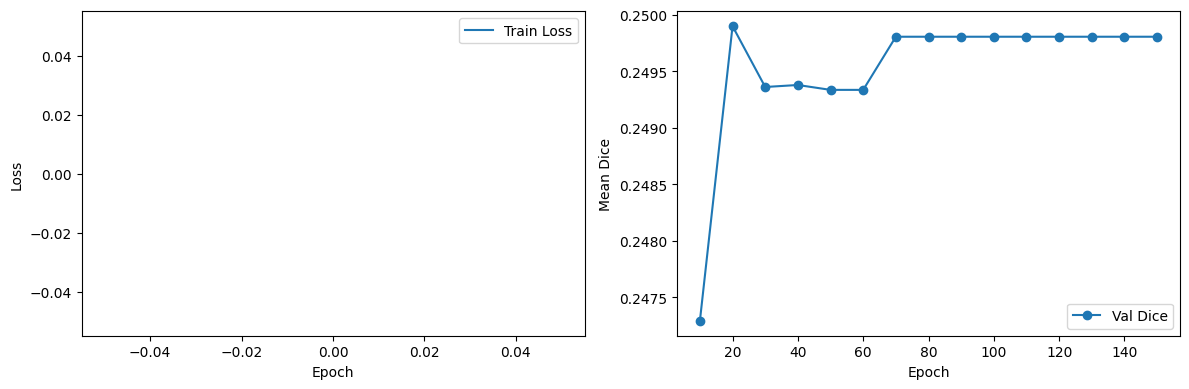

In [10]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history["val_epochs"], history["val_dice"], marker="o", label="Val Dice")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Mean Dice")
axes[1].legend()

plt.tight_layout()
plt.show()


## 5. Uncertainty Evaluation & Visualization
Load the best checkpoint, estimate predictive uncertainty with MC-dropout + TTA, and visualize entropy maps.

In [11]:

import os

best_ckpt = os.path.join(config["checkpoint_dir"], "best.pth")
if os.path.isfile(best_ckpt):
    state = torch.load(best_ckpt, map_location=device)
    model.load_state_dict(state["model_state"])
    print(f"Loaded checkpoint from epoch {state['epoch']} with Dice {state['score']:.4f}")
else:
    print("Warning: best checkpoint not found; using current model weights.")


Loaded checkpoint from epoch 20 with Dice 0.2499


In [12]:

import torch.nn.functional as F

model.eval()
val_batch = next(iter(val_loader))
inputs = val_batch["image"].to(device)
labels = val_batch["label"].to(device)

num_mc = config["num_mc_samples"] if config["use_mc_dropout"] else 1
num_tta = config["num_tta_transforms"] if config["use_tta"] else 1

with torch.no_grad():
    mean_probs, pred_entropy, epistemic_var, aleatoric_var = model.predict_with_uncertainty(
        inputs,
        num_mc_samples=num_mc,
        num_tta=num_tta,
    )

pred_labels = mean_probs.argmax(dim=1)

# Per-class Dice
per_class_dice = []
for class_idx in range(config["num_classes"]):
    pred_mask = (pred_labels == class_idx).float()
    true_mask = (labels == class_idx).float()
    inter = (pred_mask * true_mask).sum()
    denom = pred_mask.sum() + true_mask.sum()
    dice = (2 * inter + 1e-5) / (denom + 1e-5)
    per_class_dice.append(dice.item())

print("Per-class Dice (background, uterus, ovary, endometrioma):")
print(per_class_dice)

entropy_map = pred_entropy.squeeze(1)
correct_mask = (pred_labels == labels)
wrong_mask = ~correct_mask
correct_entropy = entropy_map[correct_mask].mean().item()
wrong_entropy = entropy_map[wrong_mask].mean().item()
print(f"Mean entropy -> correct voxels: {correct_entropy:.4f}, errors: {wrong_entropy:.4f}")


Per-class Dice (background, uterus, ovary, endometrioma):
[0.9980956315994263, 0.017928296700119972, 1.0183299536947743e-08, 2.857141794265772e-07]
Mean entropy -> correct voxels: 0.9508, errors: 0.7713


Saved visualization to /content/drive/MyDrive/endo-seg/experiments/results_swin_unetr/sample_uncertainty_map.png


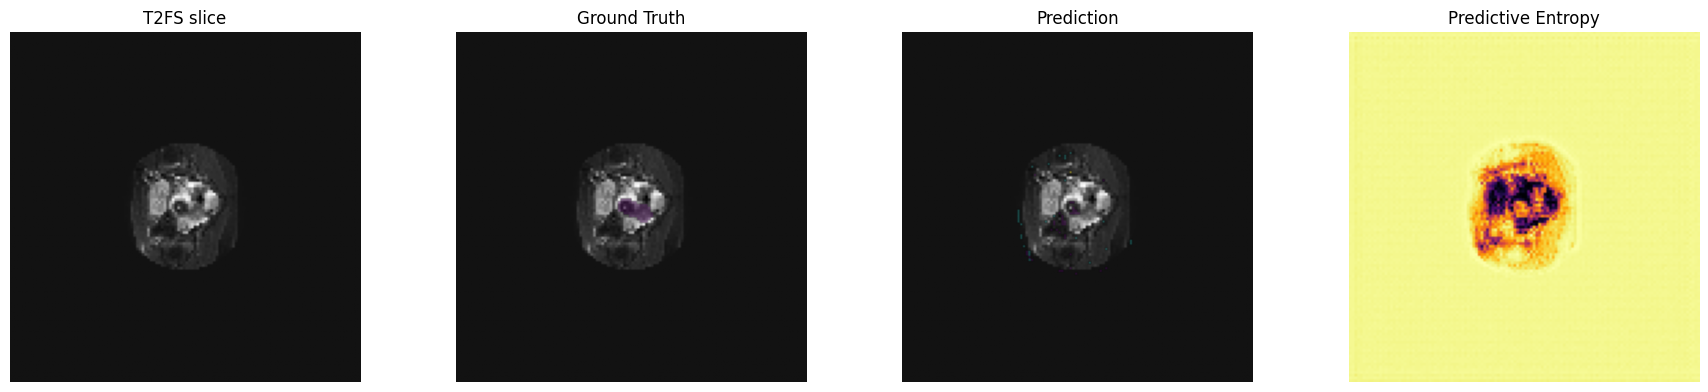

In [13]:

import numpy as np
import matplotlib.pyplot as plt

img_np = inputs[0, 0].detach().cpu().numpy()
label_np = labels[0].detach().cpu().numpy()
pred_np = pred_labels[0].detach().cpu().numpy()
entropy_np = pred_entropy[0, 0].detach().cpu().numpy()

mid_slice = img_np.shape[-1] // 2

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].imshow(img_np[:, :, mid_slice], cmap="gray")
axes[0].set_title("T2FS slice")

axes[1].imshow(img_np[:, :, mid_slice], cmap="gray")
axes[1].imshow(np.ma.masked_where(label_np[:, :, mid_slice] == 0, label_np[:, :, mid_slice]), alpha=0.4)
axes[1].set_title("Ground Truth")

axes[2].imshow(img_np[:, :, mid_slice], cmap="gray")
axes[2].imshow(np.ma.masked_where(pred_np[:, :, mid_slice] == 0, pred_np[:, :, mid_slice]), alpha=0.4)
axes[2].set_title("Prediction")

entropy_slice = entropy_np[:, :, mid_slice]
axes[3].imshow(entropy_slice, cmap="inferno")
axes[3].set_title("Predictive Entropy")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
out_dir = os.path.join(config["project_root"], "experiments", "results_swin_unetr")
os.makedirs(out_dir, exist_ok=True)
fig_path = os.path.join(out_dir, "sample_uncertainty_map.png")
plt.savefig(fig_path, dpi=150)
print(f"Saved visualization to {fig_path}")
plt.show()


## 6. Next Steps
- Toggle `config["use_finetune_on_D1"] = True` and rebuild dataloaders for D1_MHS to fine-tune on heterogeneous data.
- Train multiple seeds/checkpoints to build deep ensembles and combine with MC-dropout uncertainty for even stronger estimates.
- Extend the visualization block to export NIfTI volumes or integrate with experiment tracking dashboards (W&B/TensorBoard).